## Bayesian Statistics without Frequentist Language - Intro to STAN

### Adapted from Richard McElreath's talk (Bayes@Lund2017) - 20 Apr 2017

#### Translated to Python by Aravind S

This notebook is inspired by Richard McElreath's talk titled "Bayesian Statistics without Frequentist Language". I have linked the URL for full talk below. For this notebook, I have adapted the toy "Cat & Bird" example with which Richard outlines 3 varieties of Bayesian models i.e GLMMs, Missing Data, Measurement error - to Python. I felt it was an excellent introduction to Bayesian statistics and have personally learnt a lot from this talk. I also find it is a great domain-agnostic case study to introduce people to Bayesian statistics using STAN/Python

In [1]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/yakg94HyWdE?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

In [2]:
!pip install git+https://github.com/Arvinds-ds/stanmagic.git

  Cloning https://github.com/Arvinds-ds/stanmagic.git to /tmp/pip-k0aoliwj-build


In [3]:
%load_ext stanmagic
from __future__ import print_function, division
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import pystan
%matplotlib inline
plt.rcParams['figure.figsize'] = [12,10]
plt.style.use('seaborn-darkgrid')

In [4]:
## Stan Utility functions (Python Code Courtesy: Michael Betancourt)
def check_div(fit):
    """Check transitions that ended with a divergence"""
    sampler_params = fit.get_sampler_params(inc_warmup=False)
    divergent = [x for y in sampler_params for x in y['divergent__']]
    n = sum(divergent)
    N = len(divergent)
    print('{} of {} iterations ended with a divergence ({}%)'.format(n, N,
            100 * n / N))
    if n > 0:
        print('Try running with larger adapt_delta to remove the divergences')

def check_treedepth(fit, max_depth = 10):
    """Check transitions that ended prematurely due to maximum tree depth limit"""
    sampler_params = fit.get_sampler_params(inc_warmup=False)
    depths = [x for y in sampler_params for x in y['treedepth__']]
    n = sum(1 for x in depths if x == max_depth)
    N = len(depths)
    print(('{} of {} iterations saturated the maximum tree depth of {}'
            + ' ({}%)').format(n, N, max_depth, 100 * n / N))
    if n > 0:
        print('Run again with max_depth set to a larger value to avoid saturation')

def check_energy(fit):
    """Checks the energy Bayesian fraction of missing information (E-BFMI)"""
    sampler_params = fit.get_sampler_params(inc_warmup=False)
    for chain_num, s in enumerate(sampler_params):
        energies = s['energy__']
        numer = sum((energies[i] - energies[i - 1])**2 for i in range(1, len(energies))) / len(energies)
        denom = np.var(energies)
        if numer / denom < 0.2:
            print('Chain {}: E-BFMI = {}'.format(chain_num, numer / denom))
            print('E-BFMI below 0.2 indicates you may need to reparameterize your model')

def _by_chain(unpermuted_extraction):
    num_chains = len(unpermuted_extraction[0])
    result = [[] for _ in range(num_chains)]
    for c in range(num_chains):
        for i in range(len(unpermuted_extraction)):
            result[c].append(unpermuted_extraction[i][c])
    return np.array(result)

def _shaped_ordered_params(fit):
    ef = fit.extract(permuted=False, inc_warmup=False) # flattened, unpermuted, by (iteration, chain)
    ef = _by_chain(ef)
    ef = ef.reshape(-1, len(ef[0][0]))
    ef = ef[:, 0:len(fit.flatnames)] # drop lp__
    shaped = {}
    idx = 0
    for dim, param_name in zip(fit.par_dims, fit.extract().keys()):
        length = int(np.prod(dim))
        shaped[param_name] = ef[:,idx:idx + length]
        shaped[param_name].reshape(*([-1] + dim))
        idx += length
    return shaped

def partition_div(fit):
    """ Returns parameter arrays separated into divergent and non-divergent transitions"""
    sampler_params = fit.get_sampler_params(inc_warmup=False)
    div = np.concatenate([x['divergent__'] for x in sampler_params]).astype('int')
    params = _shaped_ordered_params(fit)
    nondiv_params = dict((key, params[key][div == 0]) for key in params)
    div_params = dict((key, params[key][div == 1]) for key in params)
    return nondiv_params, div_params

## The Cat and Bird Model

## 1. Basic Model

Imagine a room in which there is a bird which likes to sing and a cat which scares the bird. When the cat is present, the nervous bird tends to sing less and when the cat is absent, the relaxed bird tends to sing more.

![title](catbird1.png)
From Richard McElreath's presentation(Lund 2017)

The model we are interested is to find the "effect" of the cat on the bird's singing. There are 4 variables in the model

__Observed Variables__

1. Count of notes
2. Presence or absence of the cat

__Unobserved Variables__
3. Rate of singing when cat is present
4. Rate of singing when cat is absent

The Joint Model is $P(notes, cat, rate|cat\:present, rate|cat\:absent)$

In [5]:
N_days = 7 # We have only 7 data points (one per day for a week)
alpha = 20 # true rate w of singing when cat is absent
beta = 10 # true rate of singing when cat is present
np.random.seed(42)
# Simulate presence/absence of cat
cat = np.random.choice([0,1],size=N_days,replace=True,p=[0.5,0.5])
# Simulate count of notes
notes = stats.poisson((1-cat)*alpha + cat*beta).rvs(N_days)

data = OrderedDict({'N': N_days, 'cat': cat, 'notes': notes})

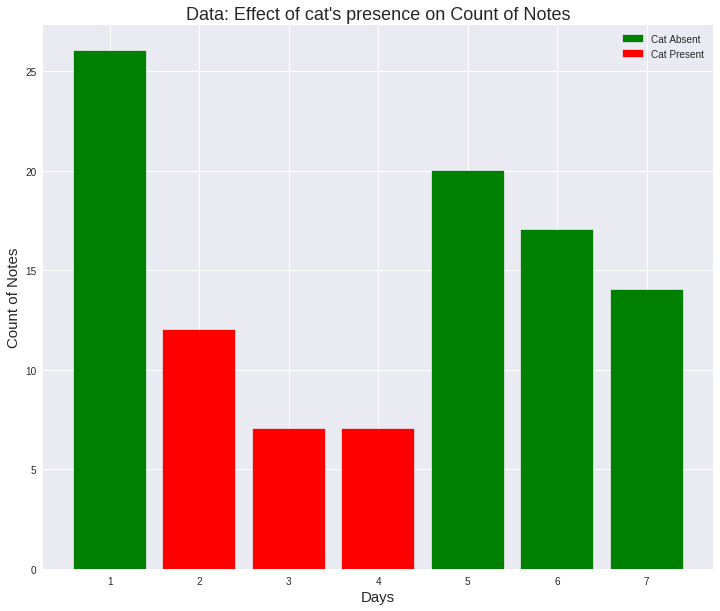

In [6]:
bar_list = plt.bar(range(1, N_days+1),notes)
[bar_list[i].set_color('g') if cat[i] == 0 else bar_list[i].set_color('r') for i in range(N_days) ]
[bar_list[i].set_label('Cat Absent') if cat[i] == 0 else bar_list[i].set_label('Cat Present') for i in range(2) ]
plt.xlabel("Days", size=15)   
plt.ylabel("Count of Notes", size=15)
plt.legend()
plt.title("Data: Effect of cat's presence on Count of Notes", size=18)

#### Basic Generative Model

$$ notes_t \sim Poisson(\lambda_t) $$
$$ \lambda_t = (1 - cat_t)\alpha + cat_t\beta $$
$$ \alpha \sim Exponential(1/10) $$
$$ \beta \sim Exponential(1/10) $$

In [7]:
%%stan -f basic_cat_and_bird.stan -v basic_model

data{
    int<lower=1> N;
    int notes[N];
    int cat[N];
}

parameters{
    real<lower=0> alpha; //rate of singing when cat is absent
    real<lower=0> beta;  // rate of singing when cate is present
}

model{
    vector[N] lambda;
    beta ~ exponential( 0.1 );
    alpha ~ exponential( 0.1 );
    for ( i in 1:N ) {
        lambda[i] = (1 - cat[i]) * alpha + cat[i] * beta;
    }
    notes ~ poisson( lambda );
}
generated quantities{
    vector[N] lambda;
    for ( i in 1:N ) {
        lambda[i] = (1 - cat[i]) * alpha + cat[i] * beta;
    }

}

Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in basic_model object.
Type basic_model in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^^^^^
Access model compile output properties
basic_model.model_file -> Name of stan_file [basic_cat_and_bird.stan]
basic_model.model_name -> Name of stan model [basic_cat_and_bird_model]
basic_model.model_code -> Model code [ data{     int<lower ....]


In [8]:
basic_model.model_code

data{
    int<lower=1> N;
    int notes[N];
    int cat[N];
}

parameters{
    real<lower=0> alpha; //rate of singing when cat is absent
    real<lower=0> beta;  // rate of singing when cate is present
}

model{
    vector[N] lambda;
    beta ~ exponential( 0.1 );
    alpha ~ exponential( 0.1 );
    for ( i in 1:N ) {
        lambda[i] = (1 - cat[i]) * alpha + cat[i] * beta;
    }
    notes ~ poisson( lambda );
}
generated quantities{
    vector[N] lambda;
    for ( i in 1:N ) {
        lambda[i] = (1 - cat[i]) * alpha + cat[i] * beta;
    }

}

In [9]:
basic_model = pystan.StanModel(file=basic_model.model_file)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b697e2cb02ac5879ce0a8acb39765c1e NOW.


In [10]:
basic_fit = basic_model.sampling(data=data, seed=42)

In [11]:
basic_fit

Inference for Stan model: anon_model_b697e2cb02ac5879ce0a8acb39765c1e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha      19.05    0.04   2.16  14.95  17.57   19.0  20.43  23.49   3618    1.0
beta        8.72    0.03   1.71   5.65   7.53   8.61    9.8  12.33   3847    1.0
lambda[0]  19.05    0.04   2.16  14.95  17.57   19.0  20.43  23.49   3618    1.0
lambda[1]   8.72    0.03   1.71   5.65   7.53   8.61    9.8  12.33   3847    1.0
lambda[2]   8.72    0.03   1.71   5.65   7.53   8.61    9.8  12.33   3847    1.0
lambda[3]   8.72    0.03   1.71   5.65   7.53   8.61    9.8  12.33   3847    1.0
lambda[4]  19.05    0.04   2.16  14.95  17.57   19.0  20.43  23.49   3618    1.0
lambda[5]  19.05    0.04   2.16  14.95  17.57   19.0  20.43  23.49   3618    1.0
lambda[6]  19.05    0.04   2.16  14.95  17.57   19.0  20.43  23.49   3618    1.0
l

In [12]:
extracted_params = basic_fit.extract(['alpha','beta'],permuted=True)

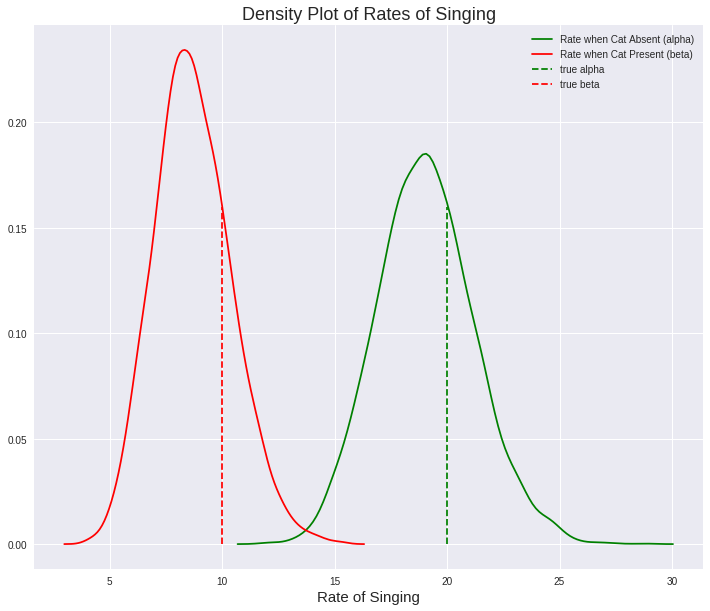

In [13]:
sns.kdeplot(extracted_params['alpha'],color='green', label='Rate when Cat Absent (alpha)')
sns.kdeplot(extracted_params['beta'],color='red', label='Rate when Cat Present (beta)')
plt.vlines(alpha,0,0.16,colors='green',linestyles='dashed',label='true alpha')
plt.vlines(beta,0,0.16,colors='red',linestyles='dashed',label='true beta')
plt.legend()
plt.xlabel('Rate of Singing', size=15)
plt.title('Density Plot of Rates of Singing', size=18)

## 2. GLMM Birds Model

![title](glmm_birds.png)
From Richard McElreath's presentation(Lund 2017)

Let us consider a Generalized Linear Mixed Model of birds (GLMM). In this model we assume there are __multiple birds__ in multiple rooms. Each bird is unique in terms of its courage and reacts differently to presence/absence of a cat. Hence we model each bird's rate of singing (under presence/absence of cat) uniquely. However, we also model the population of birds with  overall population parameters i.e population rate of singing under presence/absence of cat. This is varying effects model. We will use a __hierarchical model__ in STAN and use exponential distributions for the hyper-priors. Notice "shrinkage" arising due to hierachical model

#### GLMM - Generative Model

$$ notes_{it} \sim Poisson(\lambda_{it})$$
$$ \lambda_{it} = (1-cat_{it})\alpha_i + cat_{it}\beta_i $$
$$ \alpha_i \sim Exponential(1/\bar{\alpha})$$
$$ \beta_i \sim Exponential(1/\bar{\beta})$$
$$ \bar{\alpha} \sim Exponential(1/10) $$
$$ \bar{\beta} \sim Exponential(1/10) $$

In [14]:
N_obs = 7 # we have 7 observations (t)
N_id = 5 # we have 5 birds (i)
bird_ids = np.array([1,1,2,3,3,4,5]) # ids of birds per observation
cat = cat # reuse the cat data from first model
notes = notes # resue the notes data, simply assume it came from 5 birds over 7 observations
glmm_data = OrderedDict({'N': N_obs, 'cat': cat, 'notes': notes, 'id': bird_ids, 'N_id': N_id })

In [15]:
%%stan -f glmm_birds.stan -v glmm_birds

data{
    int<lower=1> N;
    int<lower=1> N_id;
    int notes[N];
    int cat[N];
    int id[N];
}

parameters{
    vector<lower=0>[N_id] alpha;
    vector<lower=0>[N_id] beta;
    real<lower=0> alpha_bar;
    real<lower=0> beta_bar;
}

model{
    vector[N] lambda;
    beta_bar ~ exponential( 0.1 );
    alpha_bar ~ exponential( 0.1 );
    for ( j in 1:N_id ) beta[j] ~ exponential( 1.0/beta_bar );
    for ( j in 1:N_id ) alpha[j] ~ exponential( 1.0/alpha_bar );
    for ( i in 1:N ) {
        lambda[i] = (1 - cat[i]) * alpha[id[i]] + cat[i] * beta[id[i]];
    }
    notes ~ poisson( lambda );
}

generated quantities{
    vector[N] lambda;
    for ( i in 1:N ) {
        lambda[i] = (1 - cat[i]) * alpha[id[i]] + cat[i] * beta[id[i]];
    }

}

Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in glmm_birds object.
Type glmm_birds in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^^^^
Access model compile output properties
glmm_birds.model_file -> Name of stan_file [glmm_birds.stan]
glmm_birds.model_name -> Name of stan model [glmm_birds_model]
glmm_birds.model_code -> Model code [ data{     int<lower ....]


In [16]:
glmm_model = pystan.StanModel(file='glmm_birds.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_88bfdd5d3bbdd09dc3ea5503590d2865 NOW.


In [17]:
glmm_fit = glmm_model.sampling(data=glmm_data, seed=42)

In [18]:
glmm_fit

Inference for Stan model: anon_model_88bfdd5d3bbdd09dc3ea5503590d2865.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[0]   25.15    0.08   4.88  16.54   21.7  24.89  28.27  35.25   4000    1.0
alpha[1]   18.19    0.33  20.67   0.41    4.7  11.64  24.28   74.1   4000    1.0
alpha[2]   19.74    0.07    4.4  12.17  16.68  19.42  22.51  29.14   4000    1.0
alpha[3]   16.95    0.06   4.01  10.04  14.14  16.69  19.48  25.59   4000    1.0
alpha[4]   14.14    0.06   3.74   7.84  11.41  13.78  16.46  22.33   4000    1.0
beta[0]    11.59    0.05   3.35   6.04   9.19  11.25  13.63  19.35   4000    1.0
beta[1]     7.14    0.04   2.55   3.15   5.25   6.77   8.66  13.01   4000    1.0
beta[2]     7.14    0.04    2.5   3.06   5.33   6.83   8.64  12.72   4000    1.0
beta[3]     10.7    0.22  13.62   0.24   2.63   6.17  13.69   46.3   4000    1.0
b

Note that since we have only 7 observations and 5 birds, there is huge uncertainity as evidenced by high standard deviations (some rates are below 0)

In [19]:
check_treedepth(glmm_fit)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)


In [20]:
check_energy(glmm_fit)
check_div(glmm_fit)

0.0 of 4000 iterations ended with a divergence (0.0%)


In [21]:
extracted_params = glmm_fit.extract(['alpha','beta','alpha_bar','beta_bar'],permuted=True)

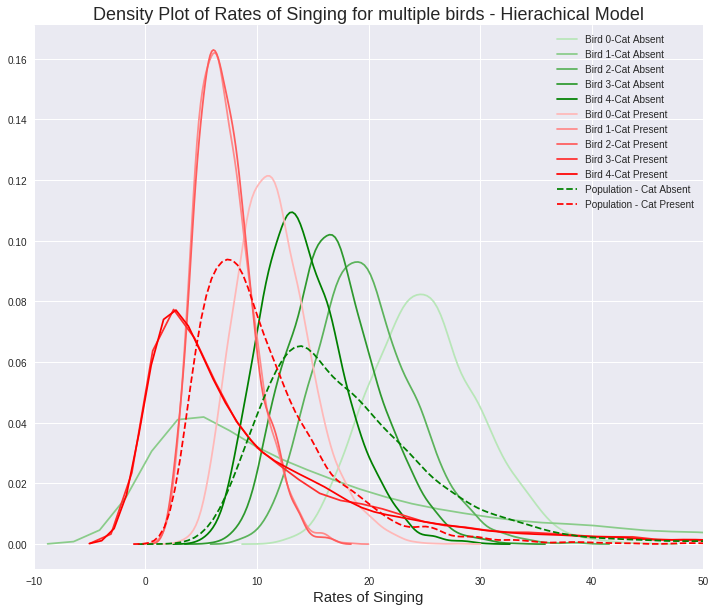

In [22]:
[sns.kdeplot(extracted_params['alpha'][:,i], color=sns.light_palette("green")[i+1], 
             label= 'Bird ' + str(i) + '-Cat Absent') for i in range(N_id)]
[sns.kdeplot(extracted_params['beta'][:,i], color=sns.light_palette("red")[i+1],
            label= 'Bird ' + str(i) + '-Cat Present') for i in range(N_id)]
sns.kdeplot(extracted_params['alpha_bar'], color=sns.light_palette("green")[5],ls='--', 
            label = 'Population - Cat Absent')
sns.kdeplot(extracted_params['beta_bar'], color=sns.light_palette("red")[5],ls='--',
           label="Population - Cat Present")
plt.xlim((-10,50))
plt.xlabel('Rates of Singing', size=15)
plt.title('Density Plot of Rates of Singing for multiple birds - Hierachical Model', size=18)

## 3. Bad Data, Good cats - Missing Data Model

Let us go back to our basic model (Model 1). Assume that for some days, we failed to log the presence of cat. We can model the presence/absence of cat with a __Bernoulli__ distribution. Since we have a joint model of all variables, the Bayesian approach allows us to impute the missing data. The variable cat now becomes data (observed) or parameter (unobserved) depending on whether the data is missing or not

#### Missing Data Generative Model

$$ notes_t \sim Poisson(\lambda_t) $$
$$ \lambda_t = (1 - cat_t)\alpha + cat_t\beta $$
$$ cat_t \sim Bernoulli(\kappa) $$
$$ \kappa \sim Beta(4,4) $$
$$ \alpha \sim Exponential(1/10) $$
$$ \beta \sim Exponential(1/10) $$

We will use Stan's log_mix function to handle the path where there is missing (this assumes the missing cat data could have arisen from either of mixture components depending on $\kappa$). See http://andrewgelman.com/2017/08/21/mixture-models-stan-can-use-log_mix/ for more details

In [23]:
N_days = 7
cat_obs = cat.copy()
cat_obs[[3,4,6]] = -1 # Data is missing on days 4,5,7. Denote missing data with -1
notes = notes # keep the notes data same
missing_data = OrderedDict({'N': N_days, 'cat': cat_obs, 'notes': notes})

In [24]:
%%stan -f missing_cat_data.stan -v missing_cat_data

data{
    int N;
    int notes[N];
    int cat[N];
}

parameters{
    real<lower=0,upper=1> kappa;
    real<lower=0> beta;
    real<lower=0> alpha;
}

model{
    beta ~ exponential( 0.1 );
    alpha ~ exponential( 0.1 );
    kappa ~ beta(4,4);
    for ( i in 1:N ) {
        if ( cat[i]==-1 ) { // cat missing
            target += log_mix( kappa ,
                    poisson_lpmf( notes[i] | beta ),
                    poisson_lpmf( notes[i] | alpha )
                );
        } else { // cat not missing
            cat[i] ~ bernoulli(kappa);
            notes[i] ~ poisson( (1-cat[i])*alpha + cat[i]*beta );
        }
    }
}

generated quantities{
    vector[N] cat_impute;
    for ( i in 1:N ) {
        real logPxy;
        real logPy;
        if ( cat[i]==-1 ) {
            // need P(cat=1|notes)
            // P(cat=1|notes) = P(cat=1,notes)/P(notes)
            // P(cat=1,notes) = P(cat=1)P(notes|cat=1 or rate = beta)
            // P(notes) = P(cat==1)P(notes|cat==1) + P(cat==0)P(notes|cat==0)
            logPxy = log(kappa) + poisson_lpmf(notes[i]|beta);
            logPy = log_mix( kappa ,
                    poisson_lpmf( notes[i] | beta ),
                    poisson_lpmf( notes[i] | alpha ) );
            cat_impute[i] = exp( logPxy - logPy );
        } else {
            cat_impute[i] = cat[i];
        }
    }
}

Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in missing_cat_data object.
Type missing_cat_data in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^^^^^^^^^^
Access model compile output properties
missing_cat_data.model_file -> Name of stan_file [missing_cat_data.stan]
missing_cat_data.model_name -> Name of stan model [missing_cat_data_model]
missing_cat_data.model_code -> Model code [ data{     int N;    ....]


In [25]:
missing_cat_model = pystan.StanModel(file='missing_cat_data.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e5efa9785e1782088c1205b4cd0ab8f0 NOW.


In [26]:
missing_cat_fit = missing_cat_model.sampling(data=missing_data, seed=42)

In [27]:
missing_cat_fit

Inference for Stan model: anon_model_e5efa9785e1782088c1205b4cd0ab8f0.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
kappa            0.5  2.1e-3   0.13   0.25   0.41    0.5   0.59   0.75   3693    1.0
beta            9.43    0.03   1.85   6.13   8.11   9.33  10.63   13.3   3133    1.0
alpha          19.63    0.05   2.57  15.05   17.9  19.45   21.2  25.14   3181    1.0
cat_impute[0]    0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0   4000    nan
cat_impute[1]    1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   4000    nan
cat_impute[2]    1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   4000    nan
cat_impute[3]   0.98  9.9e-4   0.05   0.85   0.98   0.99    1.0    1.0   2434    1.0
cat_impute[4]   0.04  1.5e-3   0.08 5.5e-5 2.2e-3   0.01   0.05    0.3   2860    1.0
cat_impute[5]    0.0     0.0    0.0    0.0    

In [28]:
extracted_params = missing_cat_fit.extract(['cat_impute'],permuted=True)

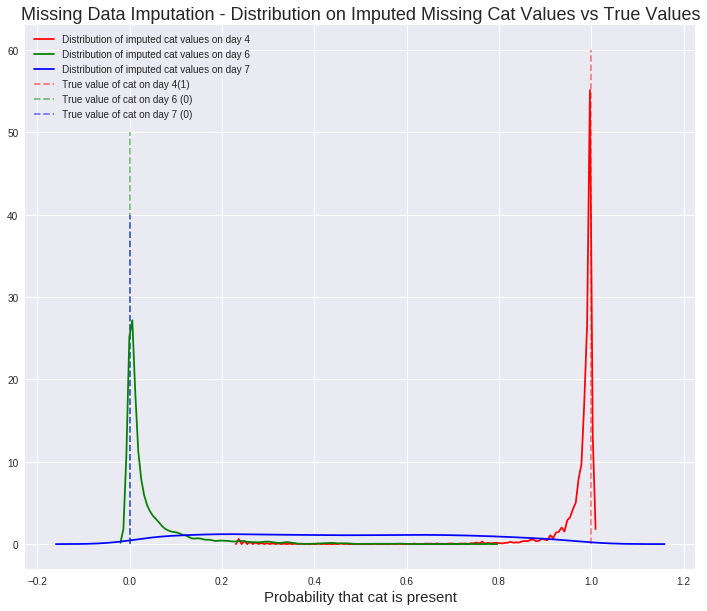

In [29]:
sns.kdeplot(extracted_params['cat_impute'][:,3],color='red', label='Distribution of imputed cat values on day 4')
sns.kdeplot(extracted_params['cat_impute'][:,4], color='green', label='Distribution of imputed cat values on day 6')
sns.kdeplot(extracted_params['cat_impute'][:,6], color='blue', label='Distribution of imputed cat values on day 7')
plt.vlines(cat[3],0,60, linestyle='dashed', alpha=0.5, color='red', label='True value of cat on day 4(1)')
plt.vlines(cat[4],0,50, linestyle='dashed', alpha=0.5, color='green', label='True value of cat on day 6 (0)')
plt.vlines(cat[6],0,40, linestyle='dashed', alpha=0.5, color='blue', label='True value of cat on day 7 (0)')
plt.legend()
plt.xlabel('Probability that cat is present', size=15)
plt.title('Missing Data Imputation - Distribution on Imputed Missing Cat Values vs True Values', size=18)

Note imputed value on Day 7 has high standard deviation. However we are imputing 3 missing values from 4 observed values

## 4. Schrödinger's Cat & Measurement Errors - Occupancy Model

Let us assume the birds are more discerning in detecting cats compared to a human observer and can detect presence of cat all the time. However, the human observer is unsure of the presence of cat. If the observed cat variable is 1, we can trust the human observer, but if the observed cat variable is 0, we cannot trust the data. When the cat observation is 0, there is a hidden variable which represents the true state of the cat.

$ cat_t $ - True state of the cat on Day t

$ cat_{obs,t} $ - Observed state of cat on Day t

$cat_{obs,t}$ depends on the true state of the cat $cat_t (0/1)$ times a detection probability $\delta$. When the cat is truly absent, $cat_{obs,t}$ is 0, else we see the cat $\delta$ % of the time

#### Occupancy - Generative Model

$$ notes_t \sim Poisson(\lambda_t) $$
$$ \lambda_t = (1 - cat_t)\alpha + cat_t\beta $$
$$ cat_{obs,t} \sim Bernoulli(cat_t\delta) $$
$$ cat_t \sim Bernoulli(\kappa) $$
$$ \kappa \sim Beta(4,4) $$
$$ \delta \sim Beta(4,4) $$
$$ \alpha \sim Exponential(1/10) $$
$$ \beta \sim Exponential(1/10) $$

In [30]:
N_days = 7
detection_prob = 0.5
np.random.seed(44)
# Simulate observed data with error - when cat is recorded as 0, the detection probability of cat is 0.5
cat_obs = np.array([0 if cat[i] == 0 else (0 if np.random.random() < (1-detection_prob) else 1) \
                    for i in range(N_days)])
notes = notes
occupancy_data = OrderedDict({'N': N_days, 'notes': notes, 'cat': cat_obs})

In [31]:
print('Truth:    ', cat)
print('Observed: ', cat_obs)
print('')

Truth:     [0 1 1 1 0 0 0]
Observed:  [0 1 0 1 0 0 0]



In [32]:
%%stan -f cat_occupancy_model.stan -v occupancy_model

data {
    int N;
    int notes[N];
    int cat[N];
}

parameters {
    real<lower=0> beta;
    real<lower=0> alpha;
    real<lower=0,upper=1> kappa;    // prob cat present
    real<lower=0,upper=1> delta;    // prob of detecting cat
}

model {
    beta ~ exponential( 0.1 );
    alpha ~ exponential( 0.1 );
    kappa ~ beta(4,4);
    delta ~ beta(4,4);
    for ( i in 1:N ) {
        if ( cat[i]==1 )
            // cat present and detected
            target += log(kappa) + log(delta) + poisson_lpmf( notes[i] | beta );
        if ( cat[i]==0 ) {
            // cat not observed, but cannot be sure not there
            // marginalize over unknown cat state:
            // (1) cat present and not detected
            // (2) cat absent
            target += log_sum_exp(
                    log(kappa) + log1m(delta) + poisson_lpmf( notes[i] | beta ),
                    log1m(kappa) + poisson_lpmf( notes[i] | alpha ) );
        }
    }
}

Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in occupancy_model object.
Type occupancy_model in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^^^^^^^^^
Access model compile output properties
occupancy_model.model_file -> Name of stan_file [cat_occupancy_model.stan]
occupancy_model.model_name -> Name of stan model [cat_occupancy_model_model]
occupancy_model.model_code -> Model code [ data {     int N;   ....]


In [33]:
occupancy_model = pystan.StanModel(file='cat_occupancy_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_610fede266c7c8bddccf674c0f01203a NOW.


In [34]:
occupancy_fit = occupancy_model.sampling(data=occupancy_data,seed=42)

In [35]:
occupancy_fit

Inference for Stan model: anon_model_610fede266c7c8bddccf674c0f01203a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta    9.38    0.04   1.93   6.04   8.04   9.25  10.59  13.62   2855    1.0
alpha   19.5    0.05   2.77  14.66  17.69  19.36  21.13  25.31   3061    1.0
kappa   0.49  2.5e-3   0.13   0.24    0.4   0.49   0.59   0.75   2835    1.0
delta   0.53  2.3e-3   0.15   0.25   0.43   0.53   0.64    0.8   4000    1.0
lp__  -35.85    0.04   1.47 -39.48 -36.56 -35.48 -34.77 -34.03   1741    1.0

Samples were drawn using NUTS at Tue Sep 12 14:52:59 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

Let us compare the true parameters vs inferred

In [36]:
extracted_params = occupancy_fit.extract(['alpha','beta','delta'],permuted=True)

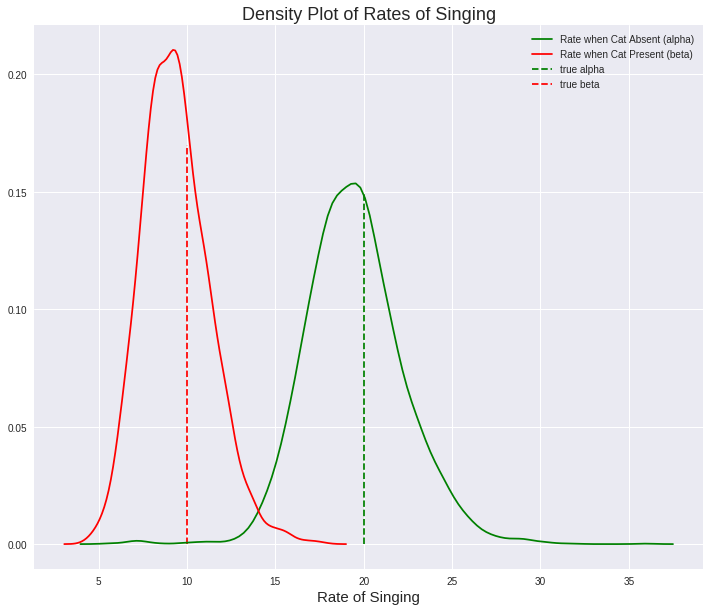

In [37]:
sns.kdeplot(extracted_params['alpha'],color='green', label='Rate when Cat Absent (alpha)')
sns.kdeplot(extracted_params['beta'],color='red', label='Rate when Cat Present (beta)')
plt.vlines(alpha,0,0.15,colors='green',linestyles='dashed',label='true alpha')
plt.vlines(beta,0,0.17,colors='red',linestyles='dashed',label='true beta')
plt.legend()
plt.xlabel('Rate of Singing', size=15)
plt.title('Density Plot of Rates of Singing', size=18)

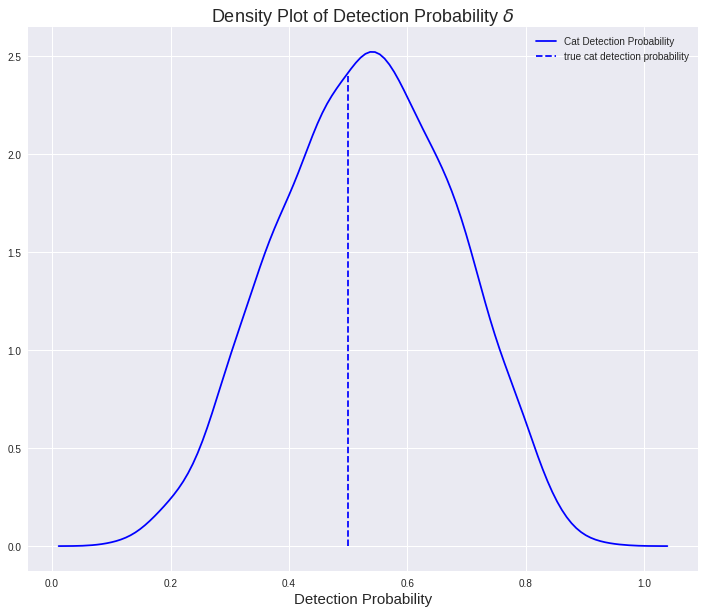

In [38]:
sns.kdeplot(extracted_params['delta'],color='blue', label='Cat Detection Probability')
plt.vlines(detection_prob,0,2.4,colors='blue',linestyles='dashed',label='true cat detection probability')
plt.legend()
plt.xlabel('Detection Probability', size=15)
plt.title('Density Plot of Detection Probability $\delta$', size=18)

## Platform

In [39]:
# conda install numpy scipy matplotlib jupyter seaborn gcc
# pip install pystan
# pip install git+https://github.com/Arvinds-ds/stanmagic.git
import matplotlib
import scipy
print('Tested on Python 2.7,3.6')
print("Numpy Version : ", np.__version__)
print("Scipy Version : ", scipy.__version__)
print("Matplotlib Version: ", matplotlib.__version__)
print("Seaborn Version", sns.__version__)
print("pystan version", pystan.__version__)
print('stanmagic extension 0.0.2')

Tested on Python 2.7,3.6
Numpy Version :  1.12.1
Scipy Version :  0.19.0
Matplotlib Version:  2.0.2
Seaborn Version 0.7.1
pystan version 2.16.0.0
stanmagic extension 0.0.2


In [40]:
assert True